In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('Set2')

In [3]:
import glob
import os

def get_latest_file_glob(pat):    
    list_of_files = glob.glob(pat) # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    return latest_file

In [4]:
latest_niv = get_latest_file_glob('data/corona_tested_individuals_ver_*.csv.gz')
niv = pd.read_csv(latest_niv, 
                  encoding='utf-8-sig', low_memory=False, na_values=['None'],
                  parse_dates=[0])
#niv['test_date'] = niv.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
niv.head()

test_date  cough  fever  sore_throat  shortness_of_breath  head_ache  \
0 2020-10-04      0      0            0                    0          0   
1 2020-10-04      0      0            0                    0          0   
2 2020-10-04      0      0            0                    0          0   
3 2020-10-04      0      0            0                    0          0   
4 2020-10-04      0      0            0                    0          0   

  corona_result age_60_and_above gender         test_indication  
0         שלילי               No    זכר                   Other  
1         שלילי               No    זכר                   Other  
2         חיובי               No   נקבה  Contact with confirmed  
3         שלילי               No    זכר                   Other  
4         שלילי              Yes   נקבה                   Other

In [5]:
symptom_cols = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']
niv['symp_num'] = niv[symptom_cols].fillna(0).sum(axis=1).astype(int)
niv['no_symp'] = (~niv[symptom_cols].fillna(0).any(axis=1))
symptom_cols.append('no_symp')


In [6]:
latest_bdi = get_latest_file_glob('data/corona_lab_tests_ver_*.csv.gz')
bdi = pd.read_csv(latest_bdi, encoding='utf-8', parse_dates=[0,1])

In [7]:
bdi['orig_test_date'] = bdi.test_date
bdi['test_date'] = bdi.test_date.combine_first(bdi.result_date)

In [8]:
bdi.head()

test_date result_date corona_result  lab_id  test_for_corona_diagnosis  \
0 2020-08-09  2020-08-09         חיובי       2                          1   
1 2020-08-09  2020-08-09         שלילי       2                          1   
2 2020-08-10  2020-08-10         שלילי       2                          1   
3 2020-03-11  2020-03-11         שלילי       3                          1   
4 2020-03-11  2020-03-11         שלילי       3                          1   

  is_first_Test orig_test_date  
0            No            NaT  
1           Yes            NaT  
2           Yes            NaT  
3           Yes     2020-03-11  
4           Yes     2020-03-11

In [9]:
bdi.shape

(3914220, 7)

In [10]:
niv.corona_result.value_counts()

שלילי    2014560
חיובי     192462
אחר        34033
Name: corona_result, dtype: int64

In [11]:
bdi.corona_result.value_counts()

שלילי               3505746
חיובי                325840
חיובי גבולי           41468
לא בוצע/פסול 999      40091
בעבודה                  678
לא ודאי                 397
Name: corona_result, dtype: int64

In [12]:
niv.corona_result.value_counts()

שלילי    2014560
חיובי     192462
אחר        34033
Name: corona_result, dtype: int64

In [13]:
niv.test_indication.value_counts()

Other                     2087963
Contact with confirmed     128250
Abroad                      24842
Name: test_indication, dtype: int64

In [14]:
niv.age_60_and_above.value_counts()

No     1525488
Yes     209169
Name: age_60_and_above, dtype: int64

In [15]:
niv.loc[(niv.test_indication=='Other') & (niv.no_symp), 'test_indication'] = 'Other-Unknown'
niv.loc[(niv.test_indication=='Other-Unknown') & (niv.age_60_and_above=='Yes'), 'test_indication'] = 'Other-60_above'
niv.loc[(niv.test_indication=='Other') & (~niv.no_symp), 'test_indication'] = 'Other-Symptoms'

In [16]:
result_map = {
    'חיובי': 'positive',
    'שלילי': 'negative',
    'אחר': 'other',
    'לא בוצע': 'not_done',
    'בעבודה': 'in_progress',
    'לא ודאי': 'uncertain',
}
niv['corona_result'] = niv.corona_result.map(result_map)


In [17]:
bdi_result_map = {
    'חיובי': 'positive',
    'שלילי': 'negative',
    'חיובי גבולי': 'borderline',
    'לא בוצע/פסול 999': 'not_done',
    'בעבודה': 'in_progress',
    'לא ודאי': 'uncertain',
}
bdi['corona_result'] = bdi.corona_result.map(bdi_result_map)

In [18]:
bdi.corona_result.value_counts()

negative       3505746
positive        325840
borderline       41468
not_done         40091
in_progress        678
uncertain          397
Name: corona_result, dtype: int64

In [19]:
rec = pd.read_csv(get_latest_file_glob('data/corona_recovered_ver_*.csv.gz'), encoding='utf-8-sig')
rec = rec.iloc[:, 0:5]
rec.head()

days_between_pos_and_neg total_tests_count age_group gender  \
0                        19                 9     40-49    זכר   
1                        22                 9     30-39    זכר   
2                        26                 9     30-39    זכר   
3                        28                 9     30-39   נקבה   
4                        23                 9     20-29   נקבה   

          test_indication  
0                  Abroad  
1  Contact with confirmed  
2  Contact with confirmed  
3                  Abroad  
4  Contact with confirmed

In [20]:
x = (rec
 .assign(total_tests_count = lambda x: (x.fillna('3').total_tests_count
                                .astype(str).str.replace('>=', '').str.replace('+', '')
                                .astype(int)))
 .groupby('total_tests_count').days_between_pos_and_neg.agg(['size', 'min', 'max', 'mean', 'median'])
).reset_index()
x['test_sum'] = x.total_tests_count*x['size']
x

total_tests_count   size  min  max       mean  median  test_sum
0                  2      6    6   17  12.833333      13        12
1                  3  11061    2  112  16.665582      17     33183
2                  4   5081    2  114  21.462114      21     20324
3                  5   3127    2  106  24.647905      25     15635
4                  6   1786    6   96  27.668533      27     10716
5                  7   1063    8  108  30.398871      30      7441
6                  8    597    3  103  33.475712      33      4776
7                  9    357    3   78  35.700280      35      3213
8                 10    573    5  106  41.130890      41      5730

In [21]:
(rec
 .assign(total_tests_count = lambda x: (x.fillna('3').total_tests_count
                                .astype(str).str.replace('>=', '').str.replace('10+', '11').replace('11+', '12')
                                .astype(int)))
 .total_tests_count.agg(['size', 'min', 'max', 'mean', 'median'])
).reset_index()

index  total_tests_count
0    size       23651.000000
1     min           2.000000
2     max          12.000000
3    mean           4.320156
4  median           4.000000

In [22]:
rec.iloc[rec.days_between_pos_and_neg.nlargest(10).index]


days_between_pos_and_neg total_tests_count age_group gender  \
9432                        114                 4       60+    זכר   
12342                       112                 3     30-39    זכר   
9304                        111                 4     20-29    זכר   
1600                        108                 7     40-49   נקבה   
6311                        106                 5     30-39    זכר   
23175                       106               10+      0-19   נקבה   
9696                        105                 4     30-39   נקבה   
456                         103                 8     50-59   נקבה   
20936                       103                 3      0-19    זכר   
23273                       100               10+       60+    זכר   

              test_indication  
9432                    Other  
12342  Contact with confirmed  
9304                    Other  
1600   Contact with confirmed  
6311   Contact with confirmed  
23175  Contact with confirmed  
9696                    Other  
456    Contact with confirmed  
20936                  Abroad  
23273  Contact with confirmed

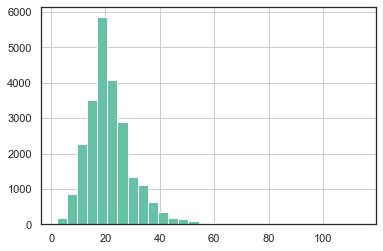

In [23]:
rec.days_between_pos_and_neg.hist(bins=30)

In [24]:
iso = pd.read_csv(get_latest_file_glob('data/corona_isolation_per_day_ver_*.csv.gz'),
                  encoding='utf-8-sig', low_memory=False)
iso.head()

date  isolated_today_contact_with_confirmed  isolated_today_abroad  \
0  2020-10-03                                  81428                  20305   
1  2020-10-02                                  85482                  20307   
2  2020-10-01                                  92629                  20920   
3  2020-09-30                                 104652                  20077   
4  2020-09-29                                 110498                  19793   

  new_contact_with_confirmed new_from_abroad  
0                       5022            1251  
1                       7371            1328  
2                      10909            2676  
3                      10773            1772  
4                      12257            2057

In [25]:
niv.dtypes

test_date              datetime64[ns]
cough                           int64
fever                           int64
sore_throat                     int64
shortness_of_breath             int64
head_ache                       int64
corona_result                  object
age_60_and_above               object
gender                         object
test_indication                object
symp_num                        int32
no_symp                          bool
dtype: object

In [26]:
niv.age_60_and_above.value_counts()

No     1525488
Yes     209169
Name: age_60_and_above, dtype: int64

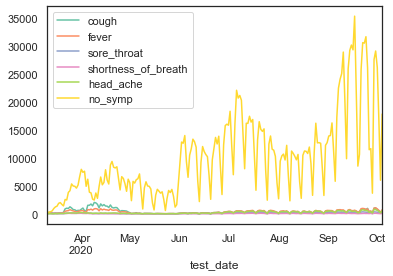

In [27]:
niv.groupby('test_date')[symptom_cols].sum().plot()

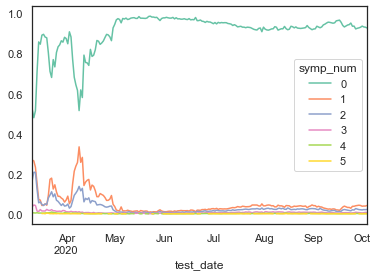

In [28]:
sn = niv.groupby(['test_date', 'symp_num']).size().unstack()
(sn.div(sn.sum(axis=1), axis=0)).plot()

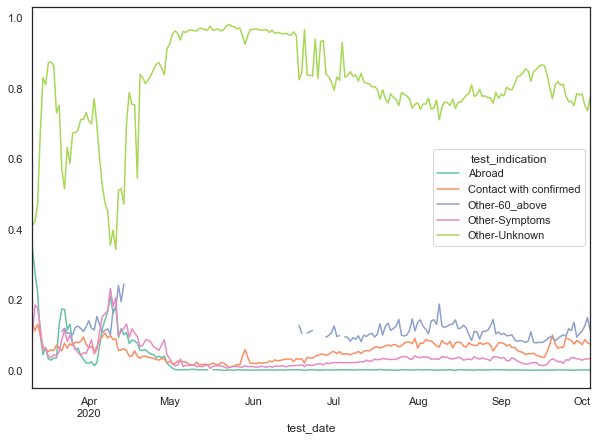

In [29]:
ti = niv.groupby(['test_date', 'test_indication']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot(figsize=(10,7))

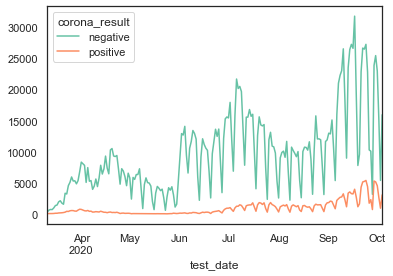

In [30]:
niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [31]:
bdi.dtypes

test_date                    datetime64[ns]
result_date                  datetime64[ns]
corona_result                        object
lab_id                                int64
test_for_corona_diagnosis             int64
is_first_Test                        object
orig_test_date               datetime64[ns]
dtype: object

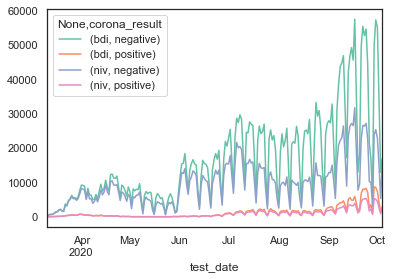

In [32]:
pd.concat([bdi[(bdi.test_date>'2020') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.test_for_corona_diagnosis)].groupby(['test_date', 'corona_result']).size().unstack(),
           niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack()], keys=['bdi', 'niv'], axis=1).plot()

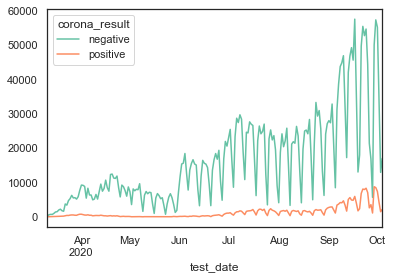

In [33]:
bdi[(bdi.test_date<'2021') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.test_for_corona_diagnosis)].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [34]:
pone = bdi[(bdi.test_date<'2021') & (bdi.test_for_corona_diagnosis)][['test_date', 'corona_result']].fillna('Other').groupby(['test_date', 'corona_result'], sort=False).size().unstack()
pone[pone.positive>20]

corona_result  positive  negative  in_progress  uncertain  not_done  \
test_date                                                             
2020-08-09       1613.0   21219.0          1.0        NaN      77.0   
2020-08-10       1859.0   21920.0          1.0        NaN     112.0   
2020-03-12         31.0     615.0          2.0        NaN       1.0   
2020-03-25        502.0    5304.0         21.0       49.0      42.0   
2020-03-13         33.0     721.0          NaN        NaN       NaN   
...                 ...       ...          ...        ...       ...   
2020-10-01       7403.0   55305.0          6.0        NaN     398.0   
2020-10-02       4262.0   33667.0          5.0        NaN     357.0   
2020-10-03       1489.0   12969.0          1.0        NaN     406.0   
2020-10-04       2180.0   17043.0          2.0        NaN     257.0   
2020-09-21       6829.0   49794.0          3.0        NaN     273.0   

corona_result  borderline  
test_date                  
2020-08-09           94.0  
2020-08-10          162.0  
2020-03-12            NaN  
2020-03-25            NaN  
2020-03-13            NaN  
...                   ...  
2020-10-01          633.0  
2020-10-02          365.0  
2020-10-03          133.0  
2020-10-04          121.0  
2020-09-21          569.0  

[197 rows x 6 columns]

In [35]:
pone.tail(5)

corona_result  positive  negative  in_progress  uncertain  not_done  \
test_date                                                             
2020-10-01       7403.0   55305.0          6.0        NaN     398.0   
2020-10-02       4262.0   33667.0          5.0        NaN     357.0   
2020-10-03       1489.0   12969.0          1.0        NaN     406.0   
2020-10-04       2180.0   17043.0          2.0        NaN     257.0   
2020-09-21       6829.0   49794.0          3.0        NaN     273.0   

corona_result  borderline  
test_date                  
2020-10-01          633.0  
2020-10-02          365.0  
2020-10-03          133.0  
2020-10-04          121.0  
2020-09-21          569.0

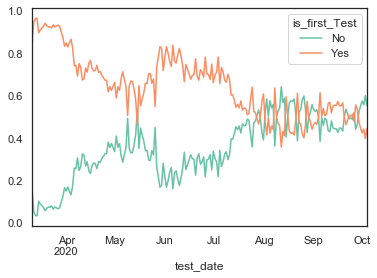

In [36]:
ti = bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')].groupby(['test_date', 'is_first_Test']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot()

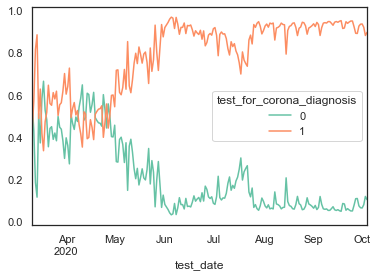

In [37]:
ti = bdi[(bdi.is_first_Test=='No')].groupby(['test_date', 'test_for_corona_diagnosis']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot()

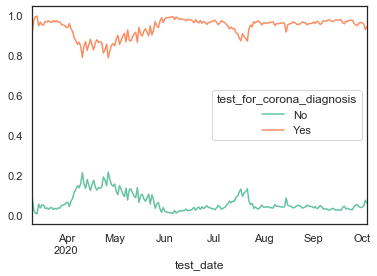

In [38]:
ti = bdi.groupby(['test_date', 'test_for_corona_diagnosis']).size().unstack()
ti = ti.rename(columns={0: 'No', 1: 'Yes'})
(ti.div(ti.sum(axis=1), axis=0)).plot()

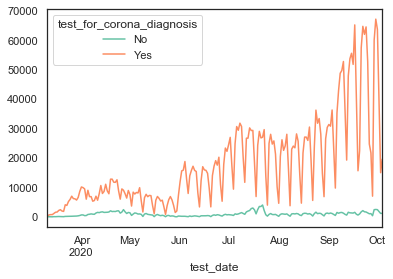

In [39]:
ti.plot()

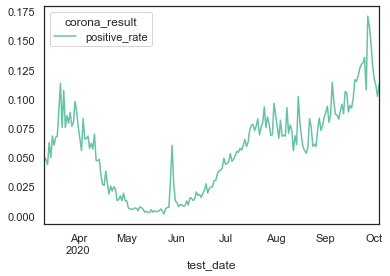

In [40]:
(bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021') & (bdi.test_for_corona_diagnosis)]
 .groupby(['test_date', 'corona_result']).size().unstack().fillna(0)
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative+x.borderline+x.uncertain))[['positive_rate']]
 .plot())

In [41]:
import altair as alt

In [42]:
ti.tail()

test_for_corona_diagnosis    No    Yes
test_date                             
2020-09-30                 2503  67199
2020-10-01                 2441  63745
2020-10-02                 1793  38656
2020-10-03                 1154  14998
2020-10-04                 1194  19603

In [43]:
ti.Yes.sum() + ti.No.sum()

3914218

In [44]:
alt.Chart(ti.reset_index().assign(total=lambda x: (x.Yes+x.No))).mark_line().encode(
    x='test_date',
    y='total',
    tooltip=['test_date', 'total']
).interactive()

alt.Chart(...)

In [45]:
pr = (bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021') & (bdi.test_for_corona_diagnosis)]
 .groupby(['test_date', 'corona_result']).size().unstack().fillna(0)
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative+x.borderline+x.uncertain)))

alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate']
).interactive()

alt.Chart(...)

In [46]:
alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive']
).interactive()

alt.Chart(...)

In [47]:
pr = (bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')
          ]
 .groupby(['test_date', 'corona_result']).size().unstack().fillna(0)
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative+x.borderline+x.uncertain)))

alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate']
).interactive()

alt.Chart(...)

In [48]:
hos_cols = {'תאריך': 'date',
            'חולים קשה': 'critical',
            'חולים בינוני': 'medium',
            'מונשמים': 'resp'}

In [49]:
hos = (pd.read_csv(get_latest_file_glob('data/corona_hospitalization_ver_*.csv.gz'), encoding='utf-8-sig', low_memory=False, na_values=['None'])
      .rename(columns=hos_cols)
      .assign(date = lambda x: x.date.apply(pd.to_datetime))
      .assign(critical = lambda x: x.critical.str.replace('<15', '15').astype(int))
      .assign(medium = lambda x: x.medium.fillna('<15').str.replace('<15', '15').astype(int))
      .assign(resp = lambda x: x.resp.str.replace('<15', '15').astype(int)))
#hos['test_date'] = hos.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
hos.head()

date  מאושפזים  אחוז נשים מאושפזות  גיל ממוצע מאושפזים  \
0 2020-03-11        76                35.5                48.0   
1 2020-03-12        98                38.8                50.0   
2 2020-03-13       116                38.8                49.0   
3 2020-03-14       154                40.9                47.0   
4 2020-03-15       193                44.0                47.0   

   סטיית תקן גיל מאושפזים  resp  אחוז נשים מונשמות  גיל ממוצע מונשמים  \
0                    17.3    15               20.0               63.0   
1                    18.0    15               20.0               63.0   
2                    17.9    15               20.0               63.0   
3                    18.2    15                0.0               70.0   
4                    18.5    15               20.0               74.0   

   סטיית תקן גיל מונשמים  חולים קל  ...  גיל ממוצע חולים קל  \
0                   15.3        69  ...                47.0   
1                   15.3        91  ...                49.0   
2                   15.3       106  ...                47.0   
3                    7.4       145  ...                46.0   
4                    7.6       179  ...                45.0   

   סטיית תקן גיל חולים קל  medium  אחוז נשים חולות בינוני  \
0                    16.7      15                     NaN   
1                    17.7      15                     NaN   
2                    17.3      15                    50.0   
3                    17.4      15                    50.0   
4                    17.5      15                    50.0   

   גיל ממוצע חולים בינוני  סטיית תקן גיל חולים בינוני  critical  \
0                     NaN                         NaN        15   
1                     NaN                         NaN        15   
2                    65.0                        17.3        15   
3                    65.0                        17.3        15   
4                    58.0                        14.9        15   

   אחוז נשים חולות קשה  גיל ממוצע חולים קשה  סטיית תקן גיל חולים קשה  
0                 33.3                 67.0                     16.2  
1                 33.3                 67.0                     16.2  
2                 33.3                 67.0                     16.2  
3                 20.0                 76.0                     10.3  
4                 37.5                 79.0                      9.1  

[5 rows x 21 columns]

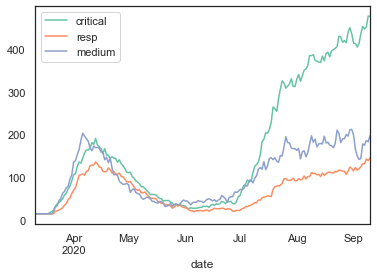

In [50]:
(hos[['date', 'critical', 'resp', 'medium']].set_index('date').plot())

In [51]:
hos_and_rate = hos[['date', 'critical', 'resp', 'medium']].rename(columns={'date': 'test_date'}).merge(pr, on='test_date')
hos_and_rate.head()


test_date  critical  resp  medium  borderline  in_progress  negative  \
0 2020-03-11        15    15      15         0.0         18.0     324.0   
1 2020-03-12        15    15      15         0.0          2.0     616.0   
2 2020-03-13        15    15      15         0.0          0.0     721.0   
3 2020-03-14        15    15      15         0.0          3.0     704.0   
4 2020-03-15        15    15      15         0.0         93.0    1025.0   

   not_done  positive  uncertain  positive_rate  
0       0.0      45.0        1.0       0.121622  
1       1.0      45.0        0.0       0.068079  
2       0.0      38.0        0.0       0.050066  
3       1.0      50.0        0.0       0.066313  
4       9.0     103.0        0.0       0.091312

In [52]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.115]
               .assign(positive_rate = lambda x: x.positive_rate.ewm(span=7).mean())
               .assign(positive_label ='positive_rate')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

In [53]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.12]
               .assign(positive = lambda x: x.positive.ewm(span=7).mean())
               .assign(positive_label ='positive')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positives (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

No handles with labels found to put in legend.


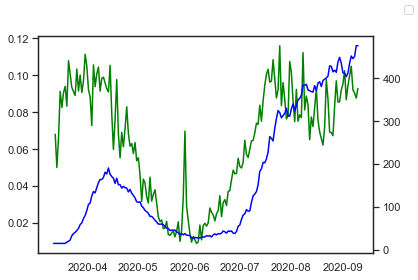

In [54]:
sns.lineplot(data=hos_and_rate[hos_and_rate.positive_rate<0.12].set_index('test_date').positive_rate, color="g")
ax2 = plt.twinx()
sns.lineplot(data=hos_and_rate.set_index('test_date').critical, color="b", ax=ax2)
ax2.figure.legend()


In [55]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.115]
               .assign(positive_rate = lambda x: x.positive_rate.ewm(span=7).mean())
               .assign(positive_label ='positive_rate')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical+med')
               .assign(crit_med = lambda x: (x.critical+x.medium).ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='crit_med',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

In [56]:
hos_and_rate['pos_pct_change'] = hos_and_rate.positive_rate.pct_change()
hos_and_rate['crit_pct_change'] = hos_and_rate.critical.pct_change()


In [57]:
c1 = alt.Chart(hos_and_rate
               .assign(pos_pct_change = lambda x: x.pos_pct_change.ewm(span=7).mean())
              ).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='pos_pct_change',
    tooltip=['test_date', 'positive_rate'],
)
c2 = alt.Chart(hos_and_rate
               .assign(crit_pct_change = lambda x: x.crit_pct_change.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='crit_pct_change',
    tooltip=['test_date', 'critical'],
)


alt.layer(c1, c2).properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

## Positive rate by Lab

In [58]:
polab = bdi[(bdi.test_date<'2021') & (bdi.test_for_corona_diagnosis)][['test_date', 'lab_id', 'corona_result']].fillna('Other').groupby(['test_date', 'lab_id', 'corona_result']).size().unstack().fillna(0)
polab['total_tests'] = polab.sum(axis=1)
polab['positive_rate'] = polab.positive/(polab.positive+polab.negative+polab.borderline+polab.uncertain)

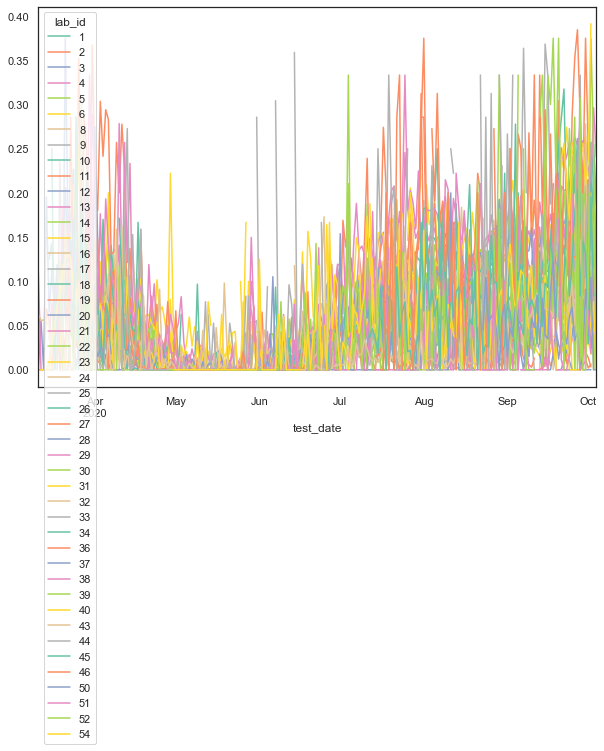

In [59]:
polab[polab.positive_rate<0.4].positive_rate.unstack().plot(figsize=(10,7))

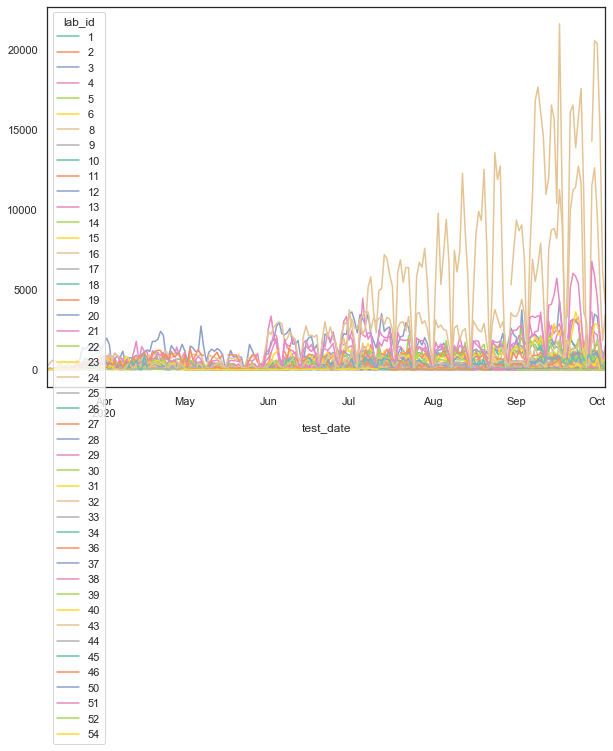

In [60]:
polab.total_tests.unstack().plot(figsize=(10,7))

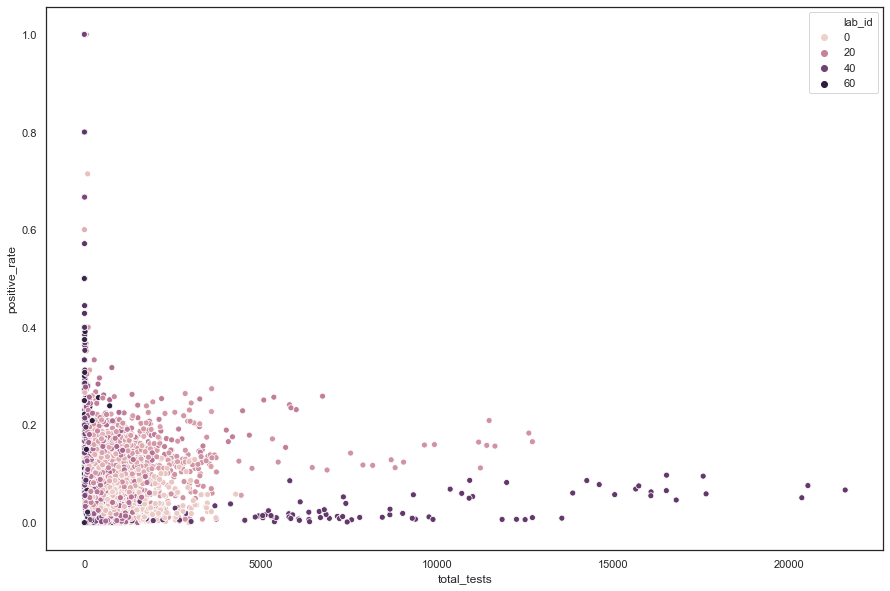

In [61]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(data=polab.reset_index(), x='total_tests', y='positive_rate', hue='lab_id')


In [62]:
import altair as alt
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [63]:
alt.Chart(polab.reset_index()).mark_point().encode(
    x='total_tests',
    y='positive_rate',
    color='lab_id:N',
    tooltip=['lab_id', 'test_date', 'total_tests', 'positive_rate']
).properties(width=600, height=450)

alt.Chart(...)

In [64]:
(polab.reset_index().groupby('lab_id')[['positive', 'negative', 'total_tests']]
 .sum().sort_values(('total_tests'), ascending=False)
 .assign(positive_rate = lambda x: (x.positive / (x.negative+x.negative)).mul(100).round(1)))

corona_result  positive  negative  total_tests  positive_rate
lab_id                                                       
43              29191.0  705325.0     745071.0            2.1
16              51683.0  430383.0     484725.0            6.0
3                9977.0  291617.0     303700.0            1.7
21              37918.0  215668.0     257694.0            8.8
13              22608.0  206031.0     234791.0            5.5
4               10122.0  139309.0     152075.0            3.6
15              19909.0  121838.0     144075.0            8.2
10              11250.0  128231.0     143834.0            4.4
12              12110.0  108458.0     122958.0            5.6
27               1174.0  109337.0     110620.0            0.5
14               9062.0   99048.0     109604.0            4.6
24               4223.0   75236.0      85326.0            2.8
6                2350.0   79027.0      84437.0            1.5
5                3954.0   73561.0      79623.0            2.7
18               4776.0   58777.0      64278.0            4.1
2                2115.0   59599.0      61989.0            1.8
8                5106.0   51376.0      56968.0            5.0
28               4286.0   47440.0      51924.0            4.5
22               3030.0   43550.0      48590.0            3.5
17               2396.0   40473.0      43830.0            3.0
9                2363.0   32758.0      37928.0            3.6
25               1715.0   33874.0      37035.0            2.5
11               2515.0   30009.0      33129.0            4.2
32               1133.0   30518.0      31791.0            1.9
26               3682.0   26095.0      30298.0            7.1
19               2901.0   22745.0      26122.0            6.4
23               1472.0   22101.0      24077.0            3.3
33                503.0   20786.0      21439.0            1.2
36                332.0   20595.0      21284.0            0.8
20                639.0   15864.0      16676.0            2.0
29                895.0   10423.0      11481.0            4.3
31                434.0    8383.0       8972.0            2.6
30                232.0    6013.0       6346.0            1.9
40                337.0    4945.0       5404.0            3.4
45                264.0    3226.0       3506.0            4.1
50                162.0    2986.0       3161.0            2.7
34                100.0    2639.0       2764.0            1.9
38                 53.0    2554.0       2615.0            1.0
54                559.0    1900.0       2515.0           14.7
37                 19.0    2432.0       2466.0            0.4
39                133.0    2130.0       2346.0            3.1
51                 34.0    1924.0       2022.0            0.9
46                184.0     743.0        927.0           12.4
44                121.0     690.0        811.0            8.8
52                 53.0     192.0        245.0           13.8
1                  18.0      43.0         68.0           20.9

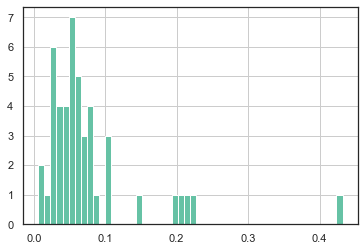

In [65]:
polab.reset_index().groupby('lab_id').positive_rate.mean().hist(bins=50)

In [66]:
top_5_labs = bdi[(bdi.test_for_corona_diagnosis==1)].lab_id.value_counts().index[:10]
top_5_labs

Int64Index([43, 16, 3, 21, 13, 4, 15, 10, 12, 27], dtype='int64')

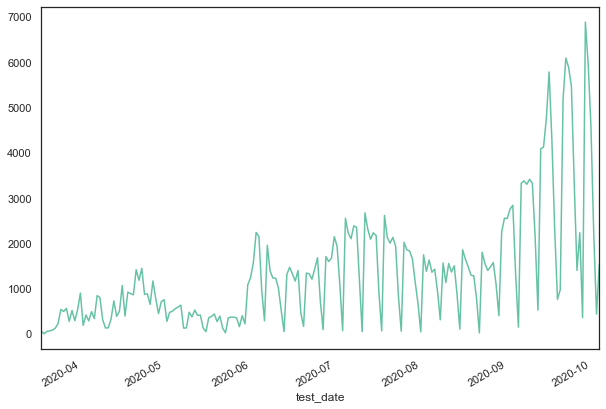

In [67]:
bdi[(bdi.lab_id==21)].groupby('test_date').size().plot(figsize=(10,7))

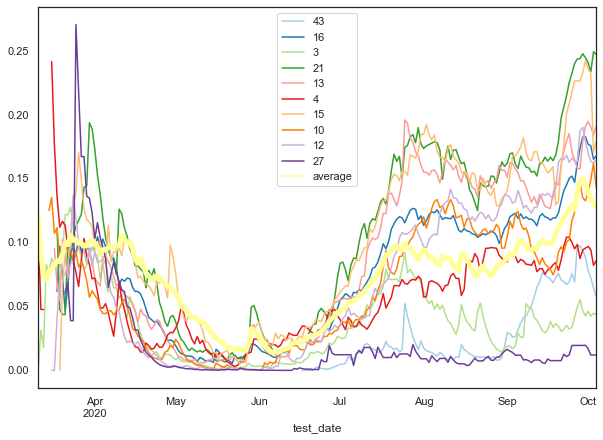

In [68]:
sns.set_palette(['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928'])
forp = pd.concat([polab.positive_rate.unstack()[top_5_labs], pr.rename(columns={'positive_rate': 'average'}).average], axis=1).ewm(span=7).mean()
ax = forp[forp<0.3].plot(figsize=(10,7))
for i, l in enumerate(ax.lines):
    plt.setp(l, linewidth=([1.5]*10+[5])[i])


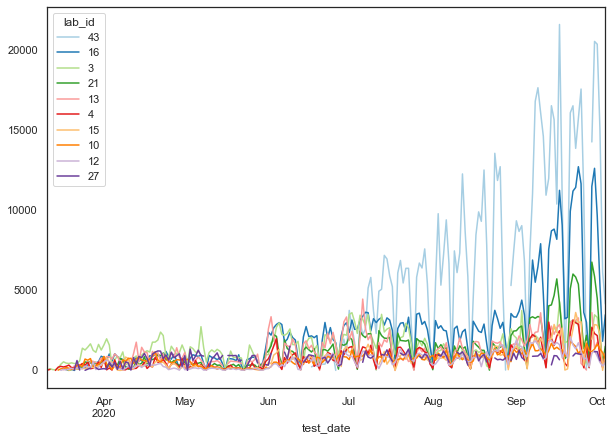

In [69]:
forp = polab.total_tests.unstack()[top_5_labs]
ax = forp.plot(figsize=(10,7))
for i, l in enumerate(ax.lines):
    plt.setp(l, linewidth=([1.5]*10+[5])[i])


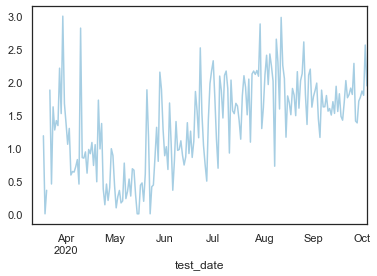

In [70]:
top_labs_pr = pd.concat([polab.positive_rate.unstack()[top_5_labs], pr.rename(columns={'positive_rate': 'average'}).average], axis=1)
top_labs_pr['ratio_21'] = top_labs_pr.loc[:, 21]/top_labs_pr.average
top_labs_pr.ratio_21.plot()

In [71]:
bdi[bdi.lab_id==21].shape[0]/bdi.shape[0]

0.0689887129491955

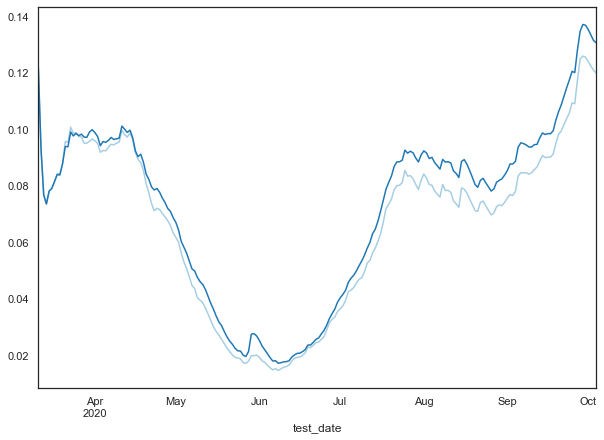

In [72]:
ax = (bdi[~(bdi.lab_id.isin([13,21]))].groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr_wo = lambda x: x.positive/(x.negative+x.positive))).pr_wo.ewm(7).mean().plot(figsize=(10,7))
(bdi.groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr = lambda x: x.positive/(x.negative+x.positive))).pr.ewm(7).mean().plot(ax=ax, figsize=(10,7))

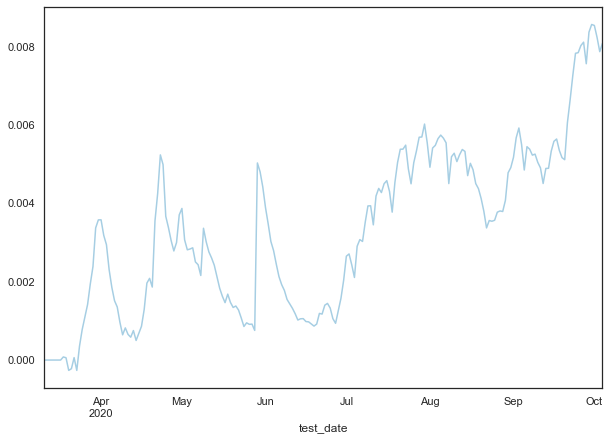

In [73]:
pd.concat([(bdi[bdi.lab_id!=21].groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr_wo = lambda x: x.positive/(x.negative+x.positive))).pr_wo,
(bdi.groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr = lambda x: x.positive/(x.negative+x.positive))).pr], axis=1).assign(dif = lambda x: x.pr-x.pr_wo).dif.ewm(7).mean().plot(figsize=(10,7))

In [74]:
alt.Chart(polab[polab.total_tests>100].reset_index()).mark_point(size=2).encode(
    x='test_date',
    y='total_tests',
    color='positive_rate:Q',
    tooltip=['lab_id', 'test_date', 'total_tests', 'positive_rate']
).properties(width=600, height=450)

alt.Chart(...)

In [75]:
xx = (polab.reset_index().groupby('lab_id')[['positive', 'negative', 'total_tests']]
 .sum().sort_values(('total_tests'), ascending=False)
 .assign(positive_rate = lambda x: (x.positive / (x.negative+x.negative)).mul(100).round(1))
 .assign(positive_rq = lambda x: pd.qcut(x.positive_rate, 5))
)
xx

corona_result  positive  negative  total_tests  positive_rate   positive_rq
lab_id                                                                     
43              29191.0  705325.0     745071.0            2.1    (1.9, 2.8]
16              51683.0  430383.0     484725.0            6.0    (4.1, 6.0]
3                9977.0  291617.0     303700.0            1.7  (0.399, 1.9]
21              37918.0  215668.0     257694.0            8.8   (6.0, 20.9]
13              22608.0  206031.0     234791.0            5.5    (4.1, 6.0]
4               10122.0  139309.0     152075.0            3.6    (2.8, 4.1]
15              19909.0  121838.0     144075.0            8.2   (6.0, 20.9]
10              11250.0  128231.0     143834.0            4.4    (4.1, 6.0]
12              12110.0  108458.0     122958.0            5.6    (4.1, 6.0]
27               1174.0  109337.0     110620.0            0.5  (0.399, 1.9]
14               9062.0   99048.0     109604.0            4.6    (4.1, 6.0]
24               4223.0   75236.0      85326.0            2.8    (1.9, 2.8]
6                2350.0   79027.0      84437.0            1.5  (0.399, 1.9]
5                3954.0   73561.0      79623.0            2.7    (1.9, 2.8]
18               4776.0   58777.0      64278.0            4.1    (2.8, 4.1]
2                2115.0   59599.0      61989.0            1.8  (0.399, 1.9]
8                5106.0   51376.0      56968.0            5.0    (4.1, 6.0]
28               4286.0   47440.0      51924.0            4.5    (4.1, 6.0]
22               3030.0   43550.0      48590.0            3.5    (2.8, 4.1]
17               2396.0   40473.0      43830.0            3.0    (2.8, 4.1]
9                2363.0   32758.0      37928.0            3.6    (2.8, 4.1]
25               1715.0   33874.0      37035.0            2.5    (1.9, 2.8]
11               2515.0   30009.0      33129.0            4.2    (4.1, 6.0]
32               1133.0   30518.0      31791.0            1.9  (0.399, 1.9]
26               3682.0   26095.0      30298.0            7.1   (6.0, 20.9]
19               2901.0   22745.0      26122.0            6.4   (6.0, 20.9]
23               1472.0   22101.0      24077.0            3.3    (2.8, 4.1]
33                503.0   20786.0      21439.0            1.2  (0.399, 1.9]
36                332.0   20595.0      21284.0            0.8  (0.399, 1.9]
20                639.0   15864.0      16676.0            2.0    (1.9, 2.8]
29                895.0   10423.0      11481.0            4.3    (4.1, 6.0]
31                434.0    8383.0       8972.0            2.6    (1.9, 2.8]
30                232.0    6013.0       6346.0            1.9  (0.399, 1.9]
40                337.0    4945.0       5404.0            3.4    (2.8, 4.1]
45                264.0    3226.0       3506.0            4.1    (2.8, 4.1]
50                162.0    2986.0       3161.0            2.7    (1.9, 2.8]
34                100.0    2639.0       2764.0            1.9  (0.399, 1.9]
38                 53.0    2554.0       2615.0            1.0  (0.399, 1.9]
54                559.0    1900.0       2515.0           14.7   (6.0, 20.9]
37                 19.0    2432.0       2466.0            0.4  (0.399, 1.9]
39                133.0    2130.0       2346.0            3.1    (2.8, 4.1]
51                 34.0    1924.0       2022.0            0.9  (0.399, 1.9]
46                184.0     743.0        927.0           12.4   (6.0, 20.9]
44                121.0     690.0        811.0            8.8   (6.0, 20.9]
52                 53.0     192.0        245.0           13.8   (6.0, 20.9]
1                  18.0      43.0         68.0           20.9   (6.0, 20.9]

In [76]:
polab = polab.reset_index()
polab['total_pr'] = polab.lab_id.map(xx.positive_rate)
polab['total_prq'] = polab.lab_id.map(xx.positive_rq)
polab = polab.set_index(['test_date', 'lab_id'])
polab.head()

corona_result      borderline  in_progress  negative  not_done  positive  \
test_date  lab_id                                                          
2020-03-11 1              0.0          0.0       0.0       0.0       2.0   
           2              0.0          0.0      70.0       0.0       0.0   
           3              0.0          1.0      36.0       0.0       0.0   
           4              0.0          0.0      16.0       0.0       2.0   
           6              0.0         16.0       0.0       0.0       0.0   

corona_result      uncertain  total_tests  positive_rate  total_pr  \
test_date  lab_id                                                    
2020-03-11 1             0.0          2.0       1.000000      20.9   
           2             0.0         70.0       0.000000       1.8   
           3             1.0         38.0       0.000000       1.7   
           4             0.0         18.0       0.111111       3.6   
           6             0.0         16.0            NaN       1.5   

corona_result         total_prq  
test_date  lab_id                
2020-03-11 1        (6.0, 20.9]  
           2       (0.399, 1.9]  
           3       (0.399, 1.9]  
           4         (2.8, 4.1]  
           6       (0.399, 1.9]

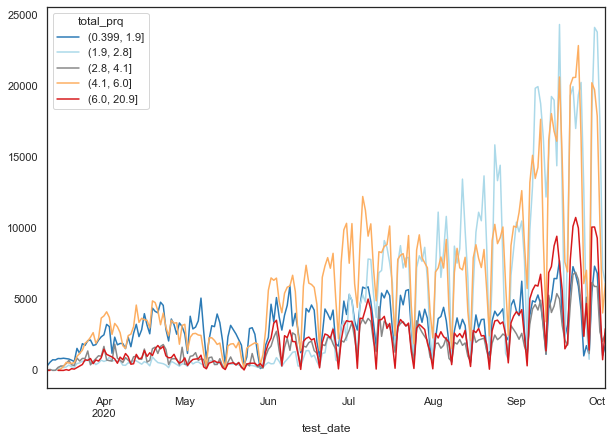

In [77]:
sns.set_palette(['#d7191c','#fdae61','#888888','#abd9e9','#2c7bb6'][::-1])
#sns.set_palette(['#fff7ec','#fee8c8','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#b30000','#7f0000'])
sns.set_style('white')
prq = (polab.reset_index()
 .groupby(['test_date', 'total_prq']).total_tests.sum()
 .unstack()
)
prq.plot(figsize=(10,7))

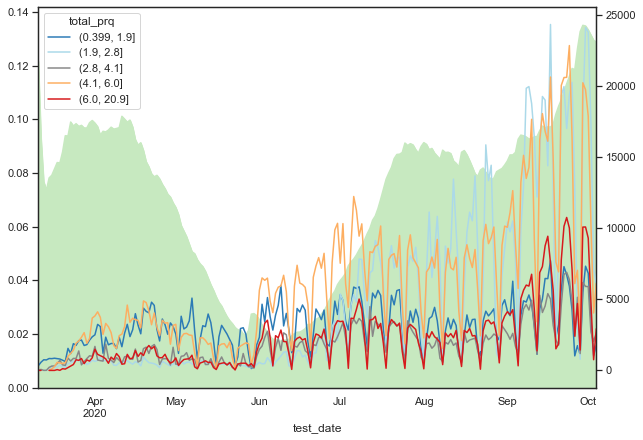

In [78]:
ax=(bdi.groupby(['test_date', 'corona_result']).size().unstack().fillna(0)
    .assign(pr = lambda x: x.positive/(x.negative+x.positive+x.borderline+x.uncertain))
   ).pr.ewm(7).mean().plot(color='#c7e9c0', kind='area', figsize=(10,7))
ax2=ax.twinx()
prq.plot(ax=ax2)

## Decseased 

In [79]:
last_dec = pd.read_csv(get_latest_file_glob('data/corona_deceased_ver*.csv.gz'), 
                       encoding='utf-8-sig', low_memory=False)
last_dec['qc'] = pd.qcut(last_dec.Length_of_hospitalization, 11, duplicates='drop')
last_dec.qc.value_counts().sort_index()/len(last_dec)

(-0.001, 2.0]    0.185531
(2.0, 4.455]     0.085764
(4.455, 6.0]     0.104434
(6.0, 8.0]       0.085764
(8.0, 10.0]      0.092765
(10.0, 13.0]     0.098016
(13.0, 16.0]     0.073512
(16.0, 21.0]     0.102100
(21.0, 29.0]     0.082264
(29.0, 154.0]    0.084014
Name: qc, dtype: float64

In [80]:
sns.set_palette('Set2')


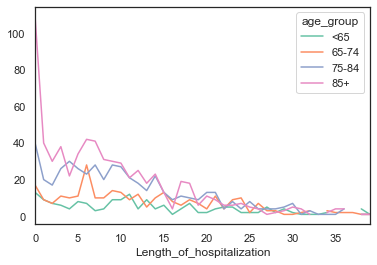

In [81]:
x = last_dec[last_dec['Length_of_hospitalization']<40].groupby(['Length_of_hospitalization', 'age_group']).size().unstack()[['<65', '65-74', '75-84', '85+']]
x.plot()

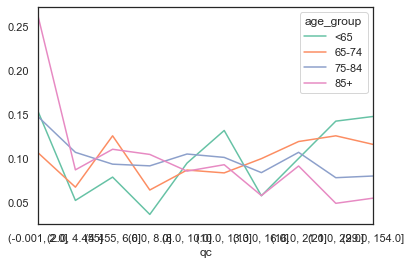

In [82]:
x = last_dec.groupby(['qc', 'age_group']).size().unstack()[['<65', '65-74', '75-84', '85+']]
x.div(x.sum(axis=0), axis=1).plot()

In [83]:
(last_dec.Length_of_hospitalization.value_counts().sort_index()/len(last_dec)).head(10)

0.0    0.104434
1.0    0.045508
2.0    0.035589
3.0    0.047258
4.0    0.038506
5.0    0.046091
6.0    0.058343
7.0    0.047841
8.0    0.037923
9.0    0.047258
Name: Length_of_hospitalization, dtype: float64

In [84]:
(last_dec.Time_between_positive_and_hospitalization.value_counts().sort_index()/len(last_dec)).head(10)

-141.0    0.000583
-36.0     0.000583
-25.0     0.000583
-22.0     0.001167
-21.0     0.002334
-17.0     0.000583
-16.0     0.001167
-15.0     0.001750
-14.0     0.001167
-13.0     0.000583
Name: Time_between_positive_and_hospitalization, dtype: float64

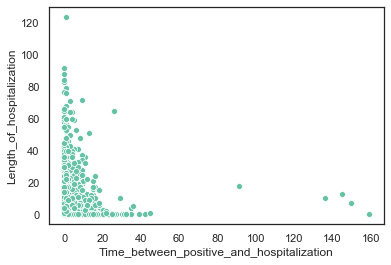

In [85]:
sns.scatterplot(data=last_dec[last_dec.Time_between_positive_and_hospitalization>=0], x='Time_between_positive_and_hospitalization', y='Length_of_hospitalization')

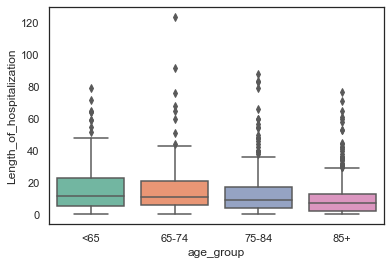

In [86]:
sns.boxplot(data=last_dec[last_dec.Time_between_positive_and_hospitalization>=0], x='age_group', y='Length_of_hospitalization', order=['<65', '65-74', '75-84', '85+'])

In [87]:
decs = []
for file in sorted(glob.glob('data/corona_deceased_ver*.csv.gz'), key=os.path.getctime) :
    dec = pd.read_csv(file, 
                  encoding='utf-8-sig', low_memory=False)
    dec['time'] = pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False)
    dec.time = dec.time
    dec['file'] = file
    decs.append(dec)

decs = pd.concat(decs).sort_values('time')
decs.head()

gender age_group  Ventilated  Time_between_positive_and_hospitalization  \
0      זכר       <65         1.0                                        2.0   
203   נקבה     75-84         1.0                                        0.0   
202   נקבה       85+         0.0                                       10.0   
201   נקבה       85+         0.0                                        2.0   
200    זכר       85+         1.0                                        0.0   

     Length_of_hospitalization  Time_between_positive_and_death  \
0                         20.0                             22.0   
203                       12.0                             12.0   
202                        1.0                             11.0   
201                       17.0                             19.0   
200                        9.0                              9.0   

                   time                                 file  
0   2020-06-16 12:09:51  data\corona_deceased_ver_001.csv.gz  
203 2020-06-16 12:09:51  data\corona_deceased_ver_001.csv.gz  
202 2020-06-16 12:09:51  data\corona_deceased_ver_001.csv.gz  
201 2020-06-16 12:09:51  data\corona_deceased_ver_001.csv.gz  
200 2020-06-16 12:09:51  data\corona_deceased_ver_001.csv.gz

In [88]:
decs.shape, (decs.drop_duplicates(subset=['gender', 'age_group', 'Ventilated',
       'Time_between_positive_and_hospitalization',
       'Length_of_hospitalization', 'Time_between_positive_and_death']).shape)

((24277, 8), (1334, 8))

In [89]:
decs.columns

Index(['gender', 'age_group', 'Ventilated',
       'Time_between_positive_and_hospitalization',
       'Length_of_hospitalization', 'Time_between_positive_and_death', 'time',
       'file'],
      dtype='object')

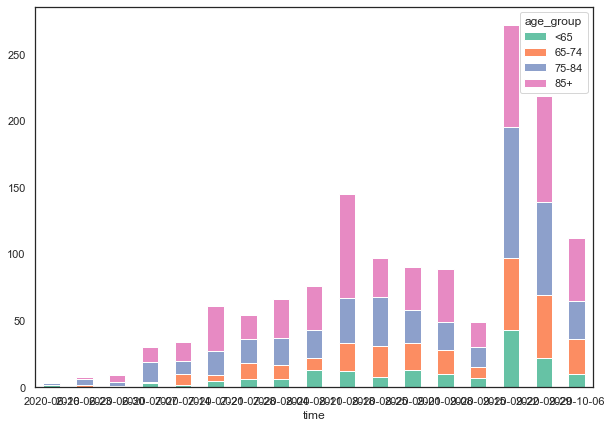

In [90]:
dec_dif = decs.groupby(['time', 'age_group']).size().unstack().diff()

dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']].plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

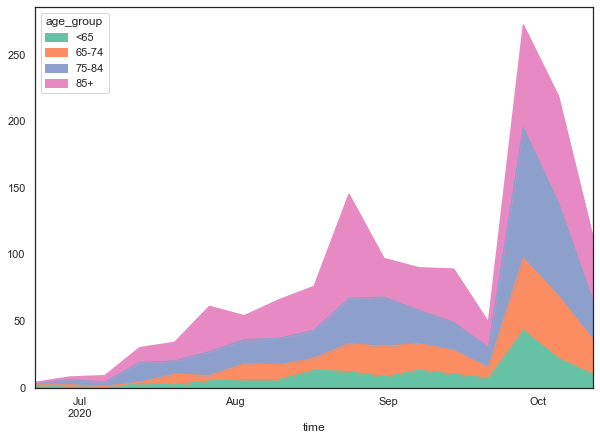

In [91]:
dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']].plot(kind='area', figsize=(10,7), rot=0)

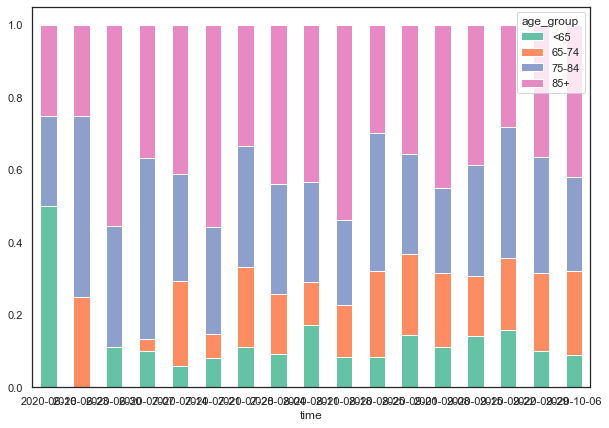

In [92]:
x = dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']]
x.div(x.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

In [93]:
dec_dif = decs.groupby(['time', 'Ventilated']).size().unstack().diff()

x = dec_dif.resample('7d', kind='period').sum()


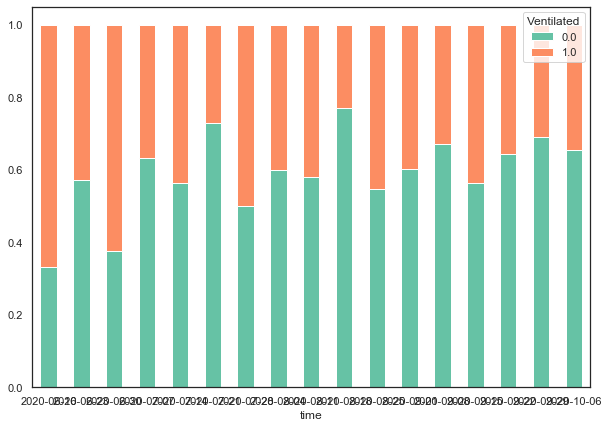

In [94]:
x.div(x.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

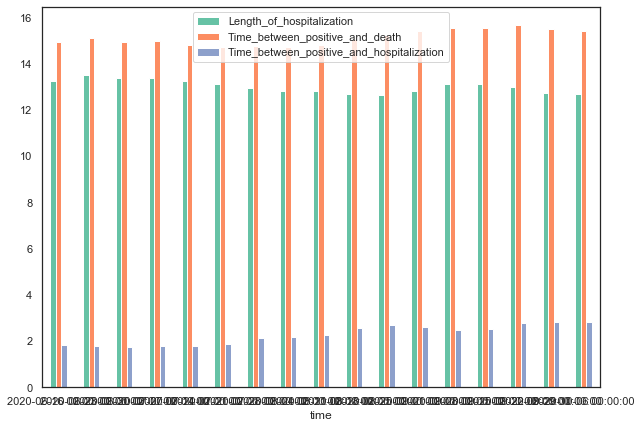

In [95]:
decs.resample('7d', on='time')[['Length_of_hospitalization', 'Time_between_positive_and_death', 'Time_between_positive_and_hospitalization']].mean().plot(kind='bar', figsize=(10,7), rot=0)


In [96]:
hos.head().T

0                    1  \
date                        2020-03-11 00:00:00  2020-03-12 00:00:00   
מאושפזים                                     76                   98   
אחוז נשים מאושפזות                         35.5                 38.8   
גיל ממוצע מאושפזים                           48                   50   
סטיית תקן גיל מאושפזים                     17.3                   18   
resp                                         15                   15   
אחוז נשים מונשמות                            20                   20   
גיל ממוצע מונשמים                            63                   63   
סטיית תקן גיל מונשמים                      15.3                 15.3   
חולים קל                                     69                   91   
אחוז נשים חולות קל                         36.2                 39.6   
גיל ממוצע חולים קל                           47                   49   
סטיית תקן גיל חולים קל                     16.7                 17.7   
medium                                       15                   15   
אחוז נשים חולות בינוני                      NaN                  NaN   
גיל ממוצע חולים בינוני                      NaN                  NaN   
סטיית תקן גיל חולים בינוני                  NaN                  NaN   
critical                                     15                   15   
אחוז נשים חולות קשה                        33.3                 33.3   
גיל ממוצע חולים קשה                          67                   67   
סטיית תקן גיל חולים קשה                    16.2                 16.2   

                                              2                    3  \
date                        2020-03-13 00:00:00  2020-03-14 00:00:00   
מאושפזים                                    116                  154   
אחוז נשים מאושפזות                         38.8                 40.9   
גיל ממוצע מאושפזים                           49                   47   
סטיית תקן גיל מאושפזים                     17.9                 18.2   
resp                                         15                   15   
אחוז נשים מונשמות                            20                    0   
גיל ממוצע מונשמים                            63                   70   
סטיית תקן גיל מונשמים                      15.3                  7.4   
חולים קל                                    106                  145   
אחוז נשים חולות קל                         38.7                 41.4   
גיל ממוצע חולים קל                           47                   46   
סטיית תקן גיל חולים קל                     17.3                 17.4   
medium                                       15                   15   
אחוז נשים חולות בינוני                       50                   50   
גיל ממוצע חולים בינוני                       65                   65   
סטיית תקן גיל חולים בינוני                 17.3                 17.3   
critical                                     15                   15   
אחוז נשים חולות קשה                        33.3                   20   
גיל ממוצע חולים קשה                          67                   76   
סטיית תקן גיל חולים קשה                    16.2                 10.3   

                                              4  
date                        2020-03-15 00:00:00  
מאושפזים                                    193  
אחוז נשים מאושפזות                           44  
גיל ממוצע מאושפזים                           47  
סטיית תקן גיל מאושפזים                     18.5  
resp                                         15  
אחוז נשים מונשמות                            20  
גיל ממוצע מונשמים                            74  
סטיית תקן גיל מונשמים                       7.6  
חולים קל                                    179  
אחוז נשים חולות קל                         44.1  
גיל ממוצע חולים קל                           45  
סטיית תקן גיל חולים קל                     17.5  
medium                                       15  
אחוז נשים חולות בינוני                       50  
גיל ממוצע חולים בינוני                       58  
סטיית תקן גיל חולים בינוני

In [97]:
rec.head()

days_between_pos_and_neg total_tests_count age_group gender  \
0                        19                 9     40-49    זכר   
1                        22                 9     30-39    זכר   
2                        26                 9     30-39    זכר   
3                        28                 9     30-39   נקבה   
4                        23                 9     20-29   נקבה   

          test_indication  
0                  Abroad  
1  Contact with confirmed  
2  Contact with confirmed  
3                  Abroad  
4  Contact with confirmed

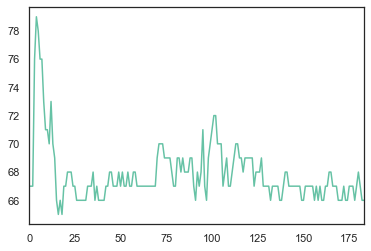

In [98]:
hos['גיל ממוצע חולים קשה'].plot()

## Recovered

In [99]:
pd.read_csv('data/corona_recovered_ver_004.csv.gz', encoding='1255')

days_between_pos_and_neg total_tests_count age_group gender  \
0                          8.0                 9     40-49   נקבה   
1                         19.0                 9     30-39    זכר   
2                         33.0                 9       60+    זכר   
3                         24.0                 9     30-39    זכר   
4                         20.0                 9     40-49    זכר   
...                        ...               ...       ...    ...   
6408                       NaN               NaN       60+    זכר   
6409                       NaN               NaN       60+   נקבה   
6410                       NaN               NaN       60+   נקבה   
6411                       NaN               NaN       60+    זכר   
6412                       NaN               NaN       60+    זכר   

             test_indication  
0     Contact with confirmed  
1     Contact with confirmed  
2                     Abroad  
3     Contact with confirmed  
4                     Abroad  
...                      ...  
6408                   Other  
6409  Contact with confirmed  
6410  Contact with confirmed  
6411                  Abroad  
6412                  Abroad  

[6413 rows x 5 columns]

In [100]:
recs = []
for file in sorted(glob.glob('data/corona_recovered*.csv.gz'), key=os.path.getctime) :
    try:
        r = pd.read_csv(file, 
                  encoding='1255', low_memory=False)
    except:
        r = pd.read_csv(file, 
                  encoding='utf-8', low_memory=False)
    print(file, pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False))
    r['time'] = pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False)
    r['file'] = file
    recs.append(r)

recs = pd.concat(recs)
recs['ver'] = recs.file.str.extract('ver_0+([1-9][0-9]*)').astype(int)
recs = recs.sort_values('ver')
recs.head()

data\corona_recovered_ver_0010.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_0012.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_004.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_005.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_006.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_007.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_008.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_0016.csv.gz 2020-06-10 10:31:01
data\corona_recovered_ver_0017.csv.gz 2020-06-11 13:45:44
data\corona_recovered_ver_0018.csv.gz 2020-06-16 12:09:51
data\corona_recovered_ver_0020.csv.gz 2020-06-19 12:31:14
data\corona_recovered_ver_0021.csv.gz 2020-06-22 19:27:14
data\corona_recovered_ver_0023.csv.gz 2020-06-28 07:56:06
data\corona_recovered_ver_0024.csv.gz 2020-06-29 09:30:26
data\corona_recovered_ver_0025.csv.gz 2020-07-02 08:39:47
data\corona_recovered_ver_0026.csv.gz 2020-07-07 11:13:23
data\corona_recovered_ver_0031.csv.gz 2020-07-12 15:47:27
data\corona_recover

days_between_pos_and_neg total_tests_count age_group gender  \
4923                      12.0                 3     30-39   נקבה   
4281                      15.0                 3     40-49   נקבה   
4280                       4.0                 3     20-29   נקבה   
4279                      13.0                 3     50-59    זכר   
4278                       7.0                 3     30-39   נקבה   

     test_indication                time  \
4923           Other 2020-05-30 14:05:58   
4281           Other 2020-05-30 14:05:58   
4280           Other 2020-05-30 14:05:58   
4279           Other 2020-05-30 14:05:58   
4278          Abroad 2020-05-30 14:05:58   

                                      file  ver  
4923  data\corona_recovered_ver_004.csv.gz    4  
4281  data\corona_recovered_ver_004.csv.gz    4  
4280  data\corona_recovered_ver_004.csv.gz    4  
4279  data\corona_recovered_ver_004.csv.gz    4  
4278  data\corona_recovered_ver_004.csv.gz    4

In [101]:
recs.ver.value_counts()

35    23651
34    21193
33    19878
32    18529
31    17913
26    16922
25    16427
24    16158
23    15883
21    15650
20    15485
18    15383
17    15254
16    15139
12    13863
10    12841
8     11251
7     10828
6      9419
5      8492
4      6413
Name: ver, dtype: int64

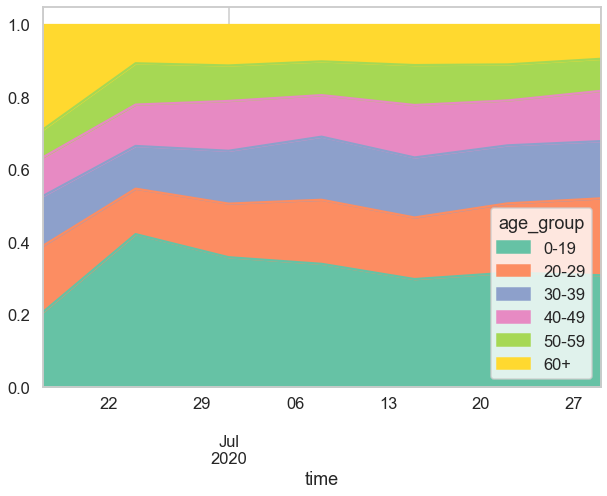

In [102]:
sns.set_style('whitegrid')
sns.set_context('talk')

rec_dif = recs[recs.ver>=17].groupby(['time', 'age_group']).size().unstack().diff()
rec_dif
x=rec_dif.resample('7d', kind='period').sum()

x.div(x.sum(axis=1),axis=0).plot(kind='area', figsize=(10,7), rot=0)

## Age & Gender

In [103]:
import gzip

def get_sep(path, encoding='utf-8'):
    if '.gz' in path:
        my_open=gzip.open
    else:
        my_open=open
    with my_open(path, 'rt', encoding=encoding) as f:
        first_line = f.readline()
    if '\t' in first_line:
        sep='\t'
    else:
        sep=','
    return sep

def get_latest_df(prefix, data_folder='data', suffix='*.csv.gz'):
    pat = os.path.join(data_folder, prefix+suffix)
    latest = get_latest_file_glob(pat)
    
    try:
        sep = get_sep(latest, '1255')
        df = pd.read_csv(latest, 
                  encoding='1255', low_memory=False, sep=sep)
    except:
        sep = get_sep(latest, 'utf-8-sig')
        df = pd.read_csv(latest, 
                  encoding='utf-8-sig', low_memory=False, sep=sep)
    return df
                
ag = get_latest_df('corona_age_and_gender')
ag.head()
    

first_week_day last_week_day age_group   gender weekly_tests_num  \
0     2020-03-15    2020-03-21      0-19     נקבה            908.0   
1     2020-03-15    2020-03-21      0-19  לא ידוע             30.0   
2     2020-03-15    2020-03-21      0-19      זכר           1091.0   
3     2020-03-15    2020-03-21     20-24      זכר            692.0   
4     2020-03-15    2020-03-21     20-24     נקבה            624.0   

  weekly_newly_tested weekly_cases weekly_deceased  
0               871.0         39.0             0.0  
1                30.0          0.0             0.0  
2              1040.0         37.0             0.0  
3               647.0        105.0             0.0  
4               604.0         34.0             0.0

In [104]:
ag.weekly_deceased.value_counts()

0.0     1006
<15      266
26.0       3
35.0       3
16.0       3
27.0       2
22.0       2
33.0       2
15.0       2
19.0       2
23.0       2
20.0       1
18.0       1
69.0       1
24.0       1
52.0       1
31.0       1
51.0       1
21.0       1
28.0       1
17.0       1
29.0       1
59.0       1
Name: weekly_deceased, dtype: int64

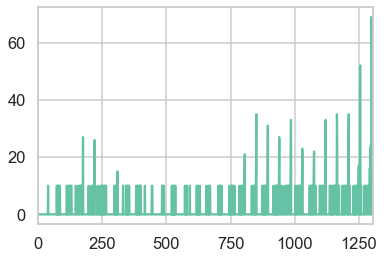

In [105]:
ag.weekly_deceased.replace('<15','10').astype(float).astype(int).plot()

## Dashboard Data

In [106]:
dash_folder = 'dashboard_data'
city_file_name = 'contagionDataPerCityPublic.csv'

In [107]:
city_df = pd.DataFrame()
for folder in os.scandir(dash_folder):
    if os.path.isdir(folder):
        for tfolder in os.scandir(folder):
            if os.path.isdir(tfolder):
                city_df = city_df.append(pd.read_csv(os.path.join(tfolder, city_file_name)), sort=False)
                
city_df['date'] = pd.to_datetime(city_df.date)
city_df.head()

city sickCount actualSick verifiedLast7Days  testLast7Days  \
0        ירושלים     16214       3748              1266          13868   
1        בני ברק      9144       1252               482           3043   
2  מודיעין עילית      3122       1085               475           2004   
3            רהט       780        240               118            792   
4       כפר קאסם       455        185               109            501   

   patientDiffPopulationForTenThousands                             status  \
0                                    40  נדרשים הסברה, בדיקות ואכיפת בידוד   
1                                    62  נדרשים הסברה, בדיקות ואכיפת בידוד   
2                                   141  נדרשים הסברה, בדיקות ואכיפת בידוד   
3                                    36  נדרשים הסברה, בדיקות ואכיפת בידוד   
4                                    77  נדרשים הסברה, בדיקות ואכיפת בידוד   

                 lastUpdate                             date  
0  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00  
1  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00  
2  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00  
3  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00  
4  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00

In [108]:
city_df.dtypes

city                                                 object
sickCount                                            object
actualSick                                           object
verifiedLast7Days                                    object
testLast7Days                                         int64
patientDiffPopulationForTenThousands                  int64
status                                               object
lastUpdate                                           object
date                                    datetime64[ns, UTC]
dtype: object

In [109]:
city_tests = (city_df
              .groupby([pd.Grouper(key='date', freq='1d'), 'city'])['testLast7Days', 'verifiedLast7Days'].max()
              .assign(positive_rate = lambda x: x.verifiedLast7Days.str.strip().replace('<15', '8').replace('1-5', '3').replace('6-10', '8').replace('11-14', '13').astype(int) / x.testLast7Days)
              .reset_index())
city_tests.head()

date                city  testLast7Days  \
0 2020-08-19 00:00:00+00:00  אבו ג'ווייעד (שבט)             12   
1 2020-08-19 00:00:00+00:00             אבו גוש            256   
2 2020-08-19 00:00:00+00:00            אבו סנאן            399   
3 2020-08-19 00:00:00+00:00   אבו קורינאת (שבט)             13   
4 2020-08-19 00:00:00+00:00   אבו רובייעה (שבט)             20   

  verifiedLast7Days  positive_rate  
0                 0       0.000000  
1                24       0.093750  
2                18       0.045113  
3                 0       0.000000  
4                 0       0.000000

In [110]:
#top_cities = city_tests.groupby('city').testLast7Days.mean().sort_values(ascending=False)[:20].index
from datetime import date, timedelta
yesterday = city_tests.date.max() - timedelta(days=1)
top_cities = city_tests[city_tests.date==yesterday].sort_values(by='testLast7Days', ascending=False).head(20).city

In [111]:
alt.Chart(city_tests[city_tests.city.isin(top_cities)]).mark_trail().encode(
    x='date',
    y='testLast7Days',
    size=alt.Size('positive_rate:Q', bin={'steps':[0.02,0.05,0.1]}),
    color='city',
    tooltip=['date', 'city', 'testLast7Days', 'positive_rate']
).properties(width=600, height=450).interactive()

alt.Chart(...)

In [112]:
alt.Chart(city_tests[city_tests.city.isin(top_cities)]).transform_joinaggregate(
     groupby = ['date'], TotalTests='sum(testLast7Days)',
).transform_calculate(
    PercentTests="datum.testLast7Days / datum.TotalTests"
).mark_area().encode(
    x='date',
    y='PercentTests:Q',
    color='city',
    #size='mean(positive_rate)',
    tooltip=['date', 'city', 'PercentTests:Q']
).properties(width=600, height=450).interactive()

alt.Chart(...)

In [113]:
alt.Chart(city_tests[city_tests.city.isin(top_cities)]).mark_trail().encode(
    x='date',
    y='positive_rate',
    size=alt.Size('testLast7Days', bin={'steps':[1000,2000,5000,10000]}),
    color='city',
    tooltip=['date', 'city', 'testLast7Days', 'positive_rate']
).properties(width=600, height=450).interactive()

alt.Chart(...)

In [114]:
ct_change = (city_tests[city_tests.date.isin(['2020-08-31',yesterday.strftime('%Y-%m-%d') ])]
 .assign(date = lambda x: x.date.dt.strftime('%Y-%m-%d'))            
 .pivot(index='city', columns='date')[['testLast7Days', 'positive_rate']]
 .assign(test_ratio=lambda x: (x.iloc[:, 1]/x.iloc[:,0]).round(2))
 .assign(pr_ratio=lambda x: (x.iloc[:, 3]/x.iloc[:,2]).round(2))
 .assign(positive_rate = lambda x: x.positive_rate.round(2))
 .sort_values(by='test_ratio', ascending=False)
 
 )
ct_change[ct_change[('testLast7Days', yesterday.strftime('%Y-%m-%d'))]>=300].head(30)#.loc[list(top_cities), :]


testLast7Days            positive_rate            test_ratio  \
date                2020-08-31 2020-10-07    2020-08-31 2020-10-07              
city                                                                            
חצור הגלילית                75        488          0.11       0.16       6.51   
שלומי                       94        379          0.03       0.09       4.03   
רכסים                      326       1256          0.12       0.21       3.85   
ירוחם                      116        431          0.03       0.11       3.72   
ערד                        346       1196          0.02       0.09       3.46   
בני ברק                   4196      14207          0.14       0.26       3.39   
באר יעקב                   311       1047          0.08       0.14       3.37   
אור עקיבא                  285        918          0.06       0.10       3.22   
גבעת זאב                   332       1067          0.07       0.18       3.21   
ירכא                       278        881          0.14       0.11       3.17   
אלעד                       858       2697          0.15       0.26       3.14   
טירת כרמל                  191        580          0.04       0.12       3.04   
עומר                       132        395          0.06       0.02       2.99   
רחובות                    1691       4851          0.05       0.14       2.87   
כוכב יעקב                  134        382          0.06       0.18       2.85   
בית שאן                    206        582          0.06       0.17       2.83   
גן יבנה                    272        763          0.03       0.12       2.81   
ביתר עילית                1080       3015          0.12       0.27       2.79   
רמלה                      1149       3135          0.08       0.14       2.73   
אופקים                     637       1730          0.08       0.13       2.72   
פקיעין (בוקייעה)           124        335          0.06       0.08       2.70   
בית שמש                   1823       4664          0.11       0.21       2.56   
אשקלון                    2183       5581          0.08       0.08       2.56   
יהוד                       379        949          0.06       0.09       2.50   
נס ציונה                   488       1222          0.05       0.10       2.50   
כפר יונה                   300        747          0.01       0.12       2.49   
יבנה                       521       1284          0.08       0.09       2.46   
קרית אתא                  1036       2523          0.04       0.07       2.44   
שדרות                      362        874          0.04       0.11       2.41   
חריש                       193        464          0.10       0.14       2.40   

                 pr_ratio  
date                       
city                       
חצור הגלילית         1.54  
שלומי                2.81  
רכסים                1.73  
ירוחם                4.13  
ערד                  4.09  
בני ברק              1.85  
באר יעקב             1.67  
אור עקיבא            1.64  
גבעת זאב             2.44  
ירכא                 0.79  
אלעד                 1.67  
טירת כרמל            2.96  
עומר                 0.33  
רחובות               2.62  
כוכב יעקב            2.94  
בית שאן              2.64  
גן יבנה              4.01  
ביתר עילית           2.20  
רמלה                 1.73  
אופקים               1.75  
פקיעין (בוקייעה)     1.25  
בית שמש              1.96  
אשקלון               1.00  
יהוד                 1.41  
נס ציונה             2.20  
כפר יונה            11.65  
יבנה                 1.12  
קרית אתא             1.88  
שדרות                2.56  
חריש                 1.37

C:\Users\dbare\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


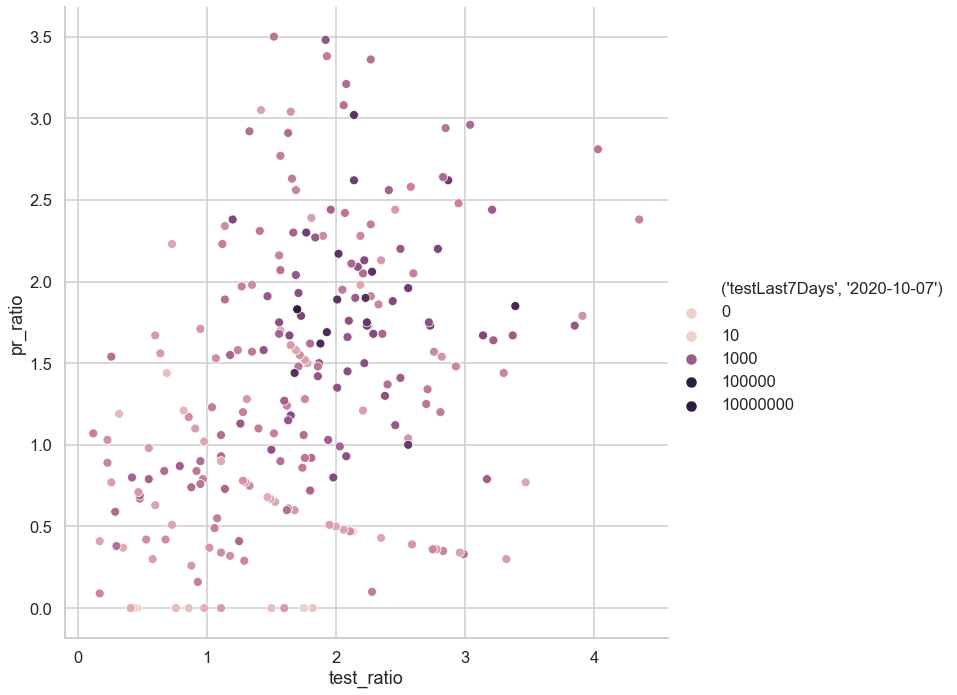

In [115]:
from matplotlib.colors import LogNorm

sns.relplot(data=ct_change[(ct_change.test_ratio<5) & (ct_change.pr_ratio<4)], x='test_ratio', y='pr_ratio', 
            hue=('testLast7Days', yesterday.strftime('%Y-%m-%d')), hue_norm=LogNorm(),
            height=10)

In [116]:
tr_file_name = 'testResultsPerDate.csv'

In [117]:
tr_df = pd.DataFrame()
for folder in os.scandir(dash_folder):
    if os.path.isdir(folder):
        for tfolder in os.scandir(folder):
            if os.path.isdir(tfolder):
                tr_df = tr_df.append(pd.read_csv(os.path.join(tfolder, tr_file_name)), sort=False)
                
tr_df['date'] = pd.to_datetime(tr_df.date)
tr_df.tail()

date  amount  amountVirusDiagnosis  positiveAmount  \
246 2020-10-04 00:00:00+00:00   26446                 24832            2936   
247 2020-10-05 00:00:00+00:00   52179                 49675            5709   
248 2020-10-06 00:00:00+00:00   47007                 44706            4698   
249 2020-10-07 00:00:00+00:00   49068                 46350            4129   
250 2020-10-08 00:00:00+00:00   17787                 16952            1174   

                   lastUpdate  
246  2020-10-08T07:33:44.060Z  
247  2020-10-08T07:33:44.060Z  
248  2020-10-08T07:33:44.060Z  
249  2020-10-08T07:33:44.060Z  
250  2020-10-08T07:33:44.060Z

In [118]:
tr_df.dtypes

date                    datetime64[ns, UTC]
amount                                int64
amountVirusDiagnosis                  int64
positiveAmount                        int64
lastUpdate                           object
dtype: object

In [119]:
tr = (tr_df.sort_values('lastUpdate', ascending=False)
              .groupby(['date']).head(1)
              .sort_values('date')
     .assign(positive_rate = lambda x: x.positiveAmount/x.amountVirusDiagnosis))
tr.tail()

date  amount  amountVirusDiagnosis  positiveAmount  \
246 2020-10-04 00:00:00+00:00   26446                 24832            2936   
247 2020-10-05 00:00:00+00:00   52179                 49675            5709   
248 2020-10-06 00:00:00+00:00   47007                 44706            4698   
249 2020-10-07 00:00:00+00:00   49068                 46350            4129   
250 2020-10-08 00:00:00+00:00   17787                 16952            1174   

                   lastUpdate  positive_rate  
246  2020-10-08T07:33:44.060Z       0.118235  
247  2020-10-08T07:33:44.060Z       0.114927  
248  2020-10-08T07:33:44.060Z       0.105087  
249  2020-10-08T07:33:44.060Z       0.089083  
250  2020-10-08T07:33:44.060Z       0.069254